## Import data 

In [1]:
#import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

I used keras/tensenflow for above cuz they have fashion_minst dataset, everything below will only be sklearn

## Data description

In [2]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
print(trainX.shape[0], 'train samples')
print(testY.shape[0], 'test samples')
print(testY[0])

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
60000 train samples
10000 test samples
9


### Onehot encode
the original data contains 0-9 which correspond to 
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
# one hot encode target values
from sklearn.preprocessing import OneHotEncoder
trainY_1hot = OneHotEncoder(sparse=False).fit_transform(trainY.reshape(-1, 1))
testY_1hot =  OneHotEncoder(sparse=False).fit_transform(testY.reshape(-1, 1))

print(trainY_1hot.shape)
print(testY_1hot[0])


(60000, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


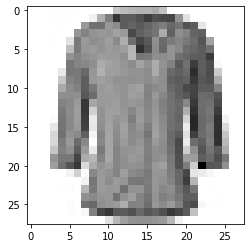

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_fashion = testX[4]
plt.imshow(some_fashion,cmap="binary")
plt.show()


The Fashion-Mnist dataset contains 28*28 pixels, so I reshape it into (n, 784)

In [5]:
#reshape data
trainX_reshape = trainX.reshape(60000, -1)
testX_reshape = testX.reshape(10000, -1)

print(trainX_reshape.shape, testX_reshape.shape)

(60000, 784) (10000, 784)


In [49]:
# use sklearn to creat a custom transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

#only for normalize, reshape and add the labels
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,class_names):
        self.class_names = class_names
    def fit(self, X, y=None):
        
        return self
    def transform(self, X, y=None):
        #reshape
        X = X.reshape(len(X), -1)
        # normalize
        X = X/255.0
        return X
        

In [44]:
#Scale/normalize/standardize features using sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
pipeline = Pipeline([
        ('custom', CustomTransformer(class_names)),
        ('std_scaler', StandardScaler())
    ])

In [45]:
trainX_pipe = pipeline.fit_transform(trainX_reshape)
testX_pipe = pipeline.transform(testX_reshape)


In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

y_train_Coat = (trainY_1hot[:, 4] == 1)
y_test_Coat = (testY_1hot[:, 4] == 1)

sgd_clf.fit(trainX_pipe, y_train_Coat)

SGDClassifier(random_state=42)

[ True]


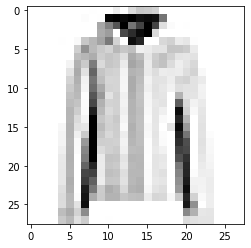

[ True]


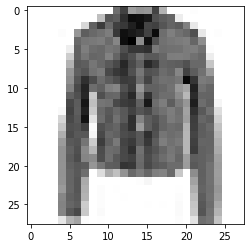

[ True]


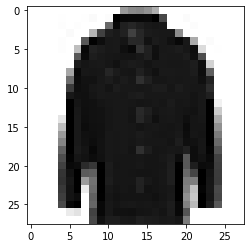

In [10]:
some_coats = testX[testY_1hot[:, 4] == 1][0:3]
for some_coat in some_coats:
    print(sgd_clf.predict(some_coat.reshape(1,784)))
    plt.imshow(some_coat,cmap="binary")
    plt.show()

[False]


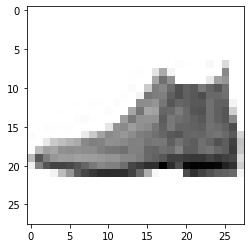

[ True]


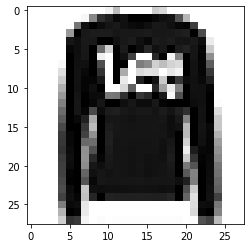

[ True]


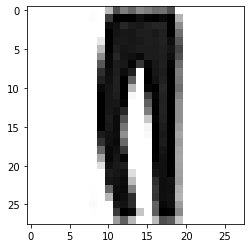

In [11]:
some_not_coats = testX[testY_1hot[:, 4] != 1][0:3]
for some_not_coat in some_not_coats:
    print(sgd_clf.predict(some_not_coat.reshape(1,784)))
    plt.imshow(some_not_coat,cmap="binary")
    plt.show()

In [12]:
#SGDClassifier StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(trainX_pipe, y_train_Coat):
    clone_clf = clone(sgd_clf)
    X_train_folds = trainX_pipe[train_index]
    y_train_folds = y_train_Coat[train_index]
    X_test_folds = trainX_pipe[test_index]
    y_test_folds = y_train_Coat[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.93685
0.93765
0.93705


Similar to the book, we have more than 90% accruacy but accuracy is generally not the preferred performance measure. 
So let's do confusion matrix!

In [13]:
#use cross_val_predict 
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, trainX_pipe, y_train_Coat, cv=3)


In [14]:
#generate confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_Coat, y_train_pred)


array([[52365,  1635],
       [ 2047,  3953]], dtype=int64)

It says 52365 of non-coats images were correctly classified as non-coats while 1635 were wrongly calssified as coats;
2047 of real coats were wrongly classified as non-coats while 3953 were correctly classified as coats.

In [15]:
#precision and recall
from sklearn.metrics import precision_score, recall_score
print("precision: ",precision_score(y_train_Coat, y_train_pred), "recall: ",recall_score(y_train_Coat, y_train_pred))


precision:  0.7074087329992842 recall:  0.6588333333333334


In [16]:
#ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_Coat, y_train_pred)
print(fpr)
print(tpr)
print(thresholds)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

from sklearn.metrics import roc_auc_score
print("AUC: ", roc_auc_score(y_train_Coat, y_train_pred))


[0.         0.03027778 1.        ]
[0.         0.65883333 1.        ]
[2 1 0]
AUC:  0.8142777777777778


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


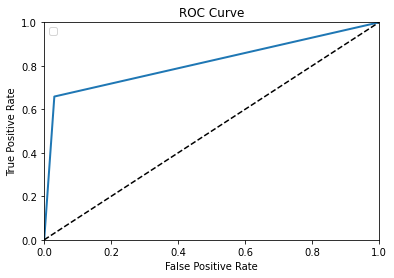

In [17]:
plot_roc_curve(fpr, tpr)

## RandomForestClassifier 

In [18]:
#random forest classfiier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_train_pred_forest = cross_val_predict(forest_clf, trainX_pipe, y_train_Coat, cv=3,method="predict_proba")


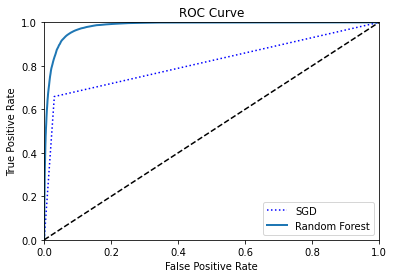

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


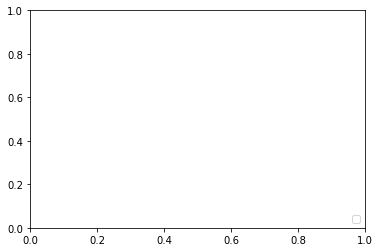

In [19]:
y_score_forest = y_train_pred_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_Coat, y_score_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


### K-Neighbors Classifer


In [20]:
from sklearn.neighbors import KNeighborsClassifier


knn_clf = KNeighborsClassifier()
knn_clf.fit(trainX_pipe, trainY_1hot)

KNeighborsClassifier()

In [21]:
#confidence of KNeighbors on test data
confidence = knn_clf.score(testX_pipe, testY_1hot)

In [22]:
print(confidence)

0.837


### OvR

one for one classifier took a long time to run so we just do one vs rest here.

In [29]:
#ovr classifer
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(KNeighborsClassifier())
ovr_clf.fit(trainX_pipe, y_train_Coat)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [28]:
#cross val score
from sklearn.model_selection import cross_val_score
cross_val_score(ovr_clf, trainX_pipe, y_train_Coat, cv=3, scoring="accuracy")


array([0.9516 , 0.95535, 0.9545 ])

### One pipeline that do it all

In [47]:
#Create a single pipeline that does full process from data preparation to final prediction
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline(steps=[
        ('custom', CustomTransformer(class_names)),
        ('std_scaler', StandardScaler()),
        ('knn_clf', KNeighborsClassifier())
])    


Use the pipeline, from original data to our prediction score:

In [48]:
model = full_pipeline.fit(trainX, trainY)
model.predict(testX)
model.score(testX, testY)

0.8533